Introduction
-----------------

Description on Kaggle: You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

In [1]:
from IPython.display import HTML, display
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load helper functions. Cannot figure out how to import these like normal.
%run ../src/helpers/utilities.py

# Needed for inline plots.
%matplotlib inline

# Default matplotlib options.
plt.rcParams['figure.figsize']=(10, 7)

In [2]:
# Load the training/test data.
train, test = pd.read_csv("../data/raw/sales_train.csv"), pd.read_csv("../data/raw/test.csv")

# Load the external data.
files = [
    "shops.csv",
    "items.csv",
    "item_categories.csv",
    "sample_submission.csv"
]

shops, items, item_categories, sample = [pd.read_csv("../data/raw/" + file) for file in files]

In [3]:
display(HTML("<h3>Columns</h3>"))
display(html_list_columns("Train: ", train.keys()))
display(html_list_columns("Test: ", test.keys()))
display(html_list_columns("Items: ", items.keys()))
display(html_list_columns("Item Categories: ", item_categories.keys()))
display(html_list_columns("Shops: ", shops.keys()))
display(html_list_columns("Sample Submission: ", sample.keys()))

In [4]:
print("Train: ", len(train)),
print("Test: ", len(test)),
print("Shops: ", len(shops)),
print("Items: ", len(items)),
print("Item Categories: ", len(item_categories))

Train:  2935849
Test:  214200
Shops:  60
Items:  22170
Item Categories:  84


In [5]:
display("Train Data:", train.head());
display("Test Data:", test.head());
display("Items:", items.head());
display("Shops:", shops.head())
display("Categories:", item_categories.head())

'Train Data:'

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


'Test Data:'

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


'Items:'

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


'Shops:'

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


'Categories:'

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
# General Description
for key, value in train.item_price.describe().items():
    print(key + ": ", "{:.2f}".format(value))

count:  2935849.00
mean:  890.85
std:  1729.80
min:  -1.00
25%:  249.00
50%:  399.00
75%:  999.00
max:  307980.00


It's odd that there's a minimum item_price of -1. How many are there?

In [7]:
(train.item_price <= 0).sum()

1

### Setting up the Target

Overall, we'll need to perform some aggregations on the training data before we train our models. But, first let's explore the dataset a little more in order to understand what we want to model.

Since our dates in the training data are in a non-standard format, so we'll clean those up first.

In [8]:
# Use python's native date format. Odd that this takes a few seconds to complete.
train["date"] = train.date.apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
train["year"] = train.date.apply(lambda x: x.year)
train["month"] = train.date.apply(lambda x: x.month)

In [9]:
# What is the min and maximum dates?
min(train.date), max(train.date)

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-10-31 00:00:00'))

We want to predict the total number of items sold during the next month. For this dataset, that would be November 2015.

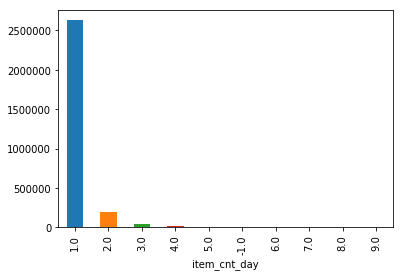

In [10]:
# Top Daily Counts.
train.item_cnt_day \
    .groupby(train.item_cnt_day) \
    .count() \
    .sort_values(ascending=False) \
    .head(10) \
    .plot(kind="bar")

The traning data is broken out by item and shop, so this tells us the vast majority of shops sell one kind of item per day. Now we'll calculate the counts per month.

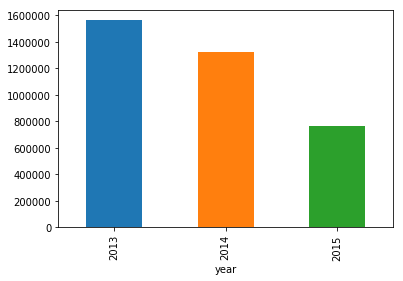

In [11]:
# Top Daily Counts.
train.item_cnt_day \
    .groupby(train.year) \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind="bar")

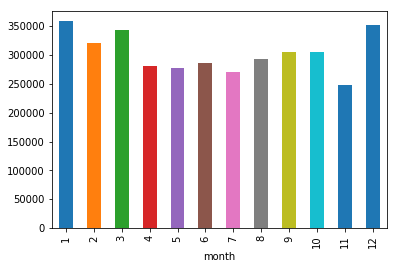

In [12]:
# Top Daily Counts.
train.item_cnt_day \
    .groupby(train.month) \
    .sum() \
    .plot(kind="bar")

We've aleady pulled out year and month into separate columns. If we use the two columns as inputs for pd.groupby we do not retain the year, month ordering that we would expect from timeseries data. To maintain the natural datetime order, we can use the datetime method to_period.

Using the pd.apply function is a real pain given that it's so slow, but it works.

In [13]:
# A create a month column.
by_month = [x.to_period("M") for x in train.date.tolist()]

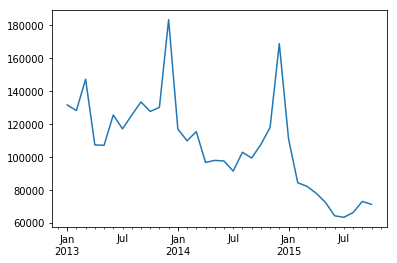

In [14]:
# Top Daily Counts.
train.item_cnt_day \
    .groupby(by_month) \
    .sum() \
    .plot(kind="line")

Seems to be a general decline in the number of items sold. Has the total $ amount of items sold seen a general decline as well?

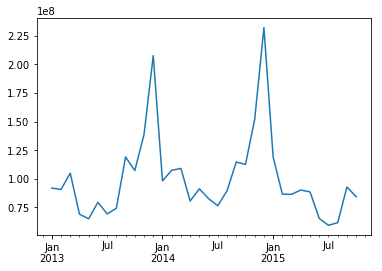

In [15]:
# By Year and Month.
(train.item_price * train.item_cnt_day) \
    .groupby(by_month) \
    .sum() \
    .plot(kind="line")

Overall, the total $ amount hasn't decreased as much as you might think given the decline in sales.

In [16]:
# General Description
for key, value in train.item_price.describe().items():
    print(key + ": ", "{:.2f}".format(value))

count:  2935849.00
mean:  890.85
std:  1729.80
min:  -1.00
25%:  249.00
50%:  399.00
75%:  999.00
max:  307980.00


It's odd that there's a minimum item_price of -1. How many are there?

In [17]:
(train.item_price < 0).sum()

1

I would expect that a negative count means a return, but that would need more exploration. Any of those?

In [18]:
(train.item_cnt_day < 0).sum()

7356

Lot more possible returns. It might be useful to create a feature counting the number of returns per month.

#### Aggregate the Training Data.

The test data that's given contains three columns: a prediction id, shop id, and item id. As established above, we want to make predictions for November, 2015. First, start by aggregating the training data using year, month, date_block_num, item_id, shop_id, and item_price. Our output will contain a sum of item_cnt_day.

In [19]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,2013-01-02,0,59,22154,999.00,1.0,2013,1
1,2013-01-03,0,25,2552,899.00,1.0,2013,1
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1


In [20]:
aggregate_by = ["year", "month", "date_block_num", "shop_id", "item_id", "item_price"]

# Create a new object. Groupby normally creates an index with each aggregate, but we discarded that with as_index.
train_agg = train.drop("date", axis=1) \
    .groupby(aggregate_by, as_index=False) \
    .sum()

In [21]:
# Rename so that the sample submission name aggress with and our training data.
train_agg.rename({"item_cnt_day": "item_cnt_month"}, axis = 1, inplace=True)

In [22]:
train_agg.head()

,year,month,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,2013,1,0,0,32,221.0,6.0
1,2013,1,0,0,33,347.0,3.0
2,2013,1,0,0,35,247.0,1.0
3,2013,1,0,0,43,221.0,1.0
4,2013,1,0,0,51,127.0,1.0


To get this ready for training, let's convert some of our columns into categorical variables. Note: There are over 22,000 different items. This creates a lot of dummy variables and takes a while to process. Any way around this?

In [23]:
to_categorical = ["year", "month", "shop_id"]

for col in to_categorical:
    train_agg[col] = train_agg[col].astype("category")

In [24]:
train_agg = pd.get_dummies(train_agg, columns=["year", "month", "shop_id"])

### Modeling

Now that we have the aggregates that we need with a small set of time-series features, let's create a simple model without joining in any features from our external datasets.

Since we know a few more things about our test dataset, let's start by adding some features that will help us create better predictions.

In [25]:
# Add our year dummy variable.
test["year_2013"], test["year_2014"], test["year_2015"] = 0, 0, 1

# Add one more consecutive month.
test["date_block_num"] = max(train.date_block_num) + 1

In [26]:
# Create a list of months and a tuple of digits. 11th digit is 1 all else 0.
for x, y in zip((["month_{}".format(i) for i in range(1, 13)]), (*tuple(0 for i in range(0, 10)), 1, 0)):
    test[x] = y

test = pd.get_dummies(test, columns=["shop_id"])

In [27]:
test.head()

,ID,item_id,year_2013,year_2014,year_2015,date_block_num,month_1,month_2,month_3,month_4,...,shop_id_48,shop_id_49,shop_id_50,shop_id_52,shop_id_53,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0,5037,0,0,1,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,5320,0,0,1,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,5233,0,0,1,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,5232,0,0,1,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5268,0,0,1,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Simple Linear Model

To get a feel for the problem, we'll start with a linear model and progressively add complexity.

In [28]:
from sklearn import linear_model, metrics, ensemble, preprocessing

In [29]:
target = 'item_cnt_month'

features = [
    "year_2015",
    "year_2014",
    "date_block_num",
    *(("month_" + str(i) for i in range(1, 12))),
    *(("shop_id_" + str(i) for i in range(1, 59)))
]

In [30]:
for missing in [feature for feature in features if feature not in test]:
    test[missing] = 0

In [31]:
# Quick check that nothing is missing with our data.
above_zero = lambda x: x[x > 0]
above_zero(train_agg[[target] + features].isna().sum().sort_values())

Series([], dtype: int64)

In [32]:
# Init
model = linear_model.LinearRegression()

# Fit.
model.fit(y=train_agg[target], X=train_agg[features])

# Predict on the training data.
train_predict = model.predict(train_agg[features])

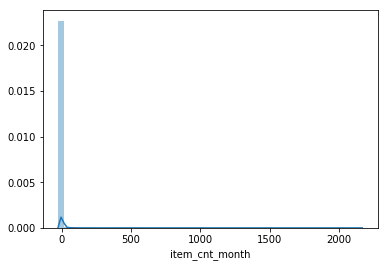

In [33]:
# Plot the difference
sns.distplot(train_agg[target] - train_predict)

[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predictions')]

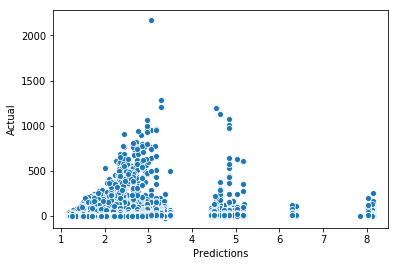

In [34]:
sns.scatterplot(x=train_predict, y=train_agg[target]) \
    .set(xlabel="Predictions", ylabel="Actual")

In [35]:
metrics.mean_squared_error(train_predict, train_agg[target])

57.78737448666379

This model does pretty poorly, but there's very little variation in the test data given that we added most of the features.

#### Random Forest

Now, we'll use an ensemble model and add item_id's to the mix. For this model, let's try re-aggregating while leaving out the pd.get_dummies step.

In [36]:
aggregate_by = ["year", "month", "date_block_num", "shop_id", "item_id", "item_price"]

# Create a new object. Groupby normally creates an index with each aggregate, but we discarded that with as_index.
train_agg = train.drop("date", axis=1) \
    .groupby(aggregate_by, as_index=False) \
    .sum()

# Rename.
train_agg.rename({"item_cnt_day": "item_cnt_month"}, axis=1, inplace=True)

# Refresh the test data.
test = pd.read_csv("../data/raw/test.csv")

# Add one more consecutive month.
test["date_block_num"] = max(train.date_block_num) + 1

# Add year and month.
test["year"], test["month"] = 2015, 11

# Convert to categorical.
# to_categorical = ["year", "month", "item_id", "shop_id"]
# for col in to_categorical:
#    test[col] = test[col].astype("category")

With our linear model, we converted a few features to a OneHotEncoding equivalent. According to [this article](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science), the Random Forest does not necessarily need data in this form to work correctly. So, we'll use the ordinal encoding.

In [37]:
target = 'item_cnt_month'

features = [
    "year",
    "month",
    "item_id",
    "shop_id"
]

In [38]:
# Init.
rf = ensemble.RandomForestRegressor(n_estimators=50)

# Fit.
rf.fit(y=train_agg[target], X=train_agg[features])

# Predict.
trpredict = rf.predict(train_agg[features])

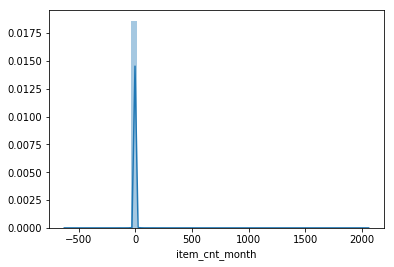

In [39]:
# Plot the difference
sns.distplot(train_agg[target] - trpredict)

In [40]:
metrics.mean_squared_error(train_agg[target], trpredict)

12.17624982679798

[(0, 1500), Text(0, 0.5, 'Actual'), (0, 1500), Text(0.5, 0, 'Predictions')]

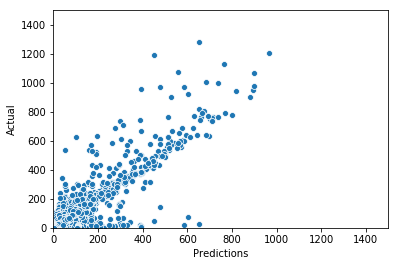

In [41]:
sns.scatterplot(x=trpredict, y=train_agg[target]) \
    .set(ylim=(0, 1500), xlim=(0, 1500), xlabel="Predictions", ylabel="Actual")

The model tends to overpredict at a couple of points.

### Adding Features

Join the items, shops, and item_categories to the training data.

In [42]:
# Does the training data maintain it's original length.
original_len = len(train)

# Merge train and items.
train = pd.merge(train, items, how="left", on="item_id")

# Merge train and shops
train = pd.merge(train, shops, how="left", on="shop_id")

# Merge train and item_categories
train = pd.merge(train, item_categories, how="left", on="item_category_id")

# Excepcted difference is 0.
len(train) - original_len

0